# Source injector

In [9]:
%%capture
from cosipy import SpacecraftFile, SourceInjector
from astropy.coordinates import SkyCoord
from threeML import Powerlaw
from pathlib import Path
import astropy.units as u
from cosipy.util import fetch_wasabi_file
import shutil
import os

The source injector can produce mock simulated data independent of the MEGAlib software.

Standard data simulation requires the users to install and use MEGAlib to convolve the source model with the detector effects to generate data. The source injector utilizes the response generated by intensive simulation, which contains the statistical detector effects. With the source injector, you can convolve response, source model, and orientation to gain the mock data quickly. 

The advantages of using the source injector include:

- No need to install and use MEGAlib
- Get the data much faster than the standard simulation pipeline
- The generated data are in the format that can be used for spectral fitting, localization, imaging, etc.

The disadvantages are:

- The data are binned based on the binning of the response, which means that you lost the unbinned event distribution as you will get from the MEGAlib pipeline.
- If the response is coarse, the data you generated might not be precise.

## Download data 

In [13]:
data_dir = Path("") # Current directory by default. Modify if you want a different path

In [14]:
%%capture
zipped_response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip"
response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5"

# download response file ~839.62 MB
if not response_path.exists():
    
    fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip", zipped_response_path)

    # unzip the response file
    shutil.unpack_archive(zipped_response_path)
    
    # delete the zipped response to save space
    os.remove(zipped_response_path)

In [15]:
%%capture
orientation_path = data_dir/"20280301_3_month.ori"

# download orientation file ~684.38 MB
if not orientation_path.exists():
    fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori", orientation_path)

## Inject a point source response

### Define the spectrum model

In [3]:
index = -2.2
K = 1 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value= piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

### Read orientation file

In [7]:
# Read the 3-month orientation
# It is the pointing of the spacecraft during the the mock simlulation
ori = SpacecraftFile.parse_from_file(orientation_path)

### Get the expected counts and save to a data file

In [8]:
# Define an injector by the response
injector = SourceInjector(response_path = response_path)

In [9]:
# Define the coordinate of the point source
source_coord = SkyCoord(l = 184.5551, b = -05.7877, frame = "galactic", unit = "deg")

CPU times: user 9.03 s, sys: 2.95 s, total: 12 s
Wall time: 19.3 s


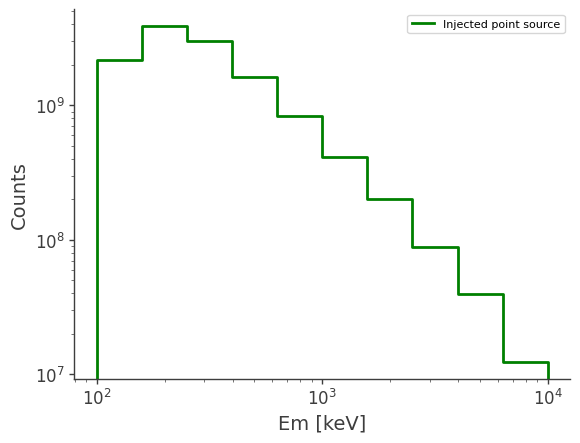

In [13]:
%%time
# Get the data of the injected source
injector.inject_point_source(spectrum = spectrum, coordinate = source_coord, orientation = ori, source_name = "point_source",
                             make_spectrum_plot = True, data_save_path = "test_injected.h5", project_axes = None)